In [2]:
%pylab inline
import pandas as pd
import scanpy as sc

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def postprocess(adata,view=True):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
    print('after select HVG',adata.shape)
    sc.pp.scale(adata)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    if view:
        sc.tl.umap(adata)
    return adata

In [4]:
def cluster_k_leiden(embadata,n_cluster):
    max_steps=120
    this_step = 0
    this_min = 0
    this_max = 2
    print('reference cluster number',n_cluster)
    while this_step < max_steps:
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.leiden(embadata,resolution=this_resolution,random_state=42)
        this_clusters = embadata.obs['leiden'].nunique()
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:break
        this_step+=1
    if this_step==max_steps:
        print('Cannot find the number of clusters')
        print('Use resolution',this_resolution)
    else:
        print('use resolution',this_resolution)
     # leiden
    sc.tl.leiden(embadata,resolution=this_resolution,random_state=42,key_added=f'cluster_{n_cluster}')

## Baron

In [4]:
refdf = pd.read_csv('./data/baron_human_ref_19264_fromsaver.csv',index_col=0)

In [6]:
refAdata = sc.AnnData(refdf)
refAdata = postprocess(refAdata,True)

/tmp/ipykernel_43999/897376523.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  refAdata = sc.AnnData(refdf)


after select HVG (1076, 432)


/opt/conda/envs/scvi/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
sc.tl.leiden(refAdata,resolution=0.6)

In [8]:
numcls = refAdata.obs.leiden.unique().shape[0]
numcls

7

In [9]:
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

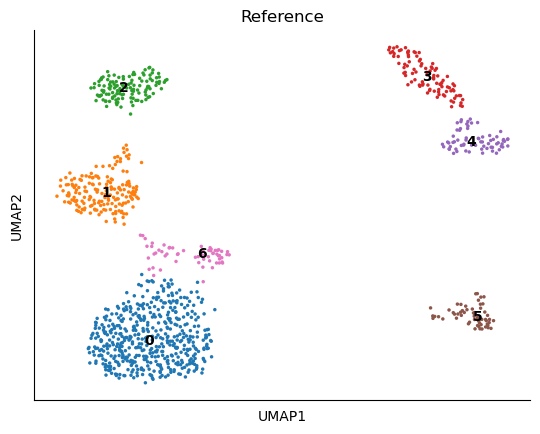

In [10]:
sc.pl.umap(refAdata,color=[f'leiden'],size=25,title='Reference',legend_loc='on data',save='reference')

### concat embedding

In [24]:
imputeemb = np.load(f'../../imputation/SAVER/baron/baron_human_samp_19264_fromsaver_50M-0.1B-res_tgthighres5_embedding.npy')
imputeAdata = sc.AnnData(pd.DataFrame(imputeemb,index=refdf.index))
sc.pp.scale(imputeAdata)
sc.tl.pca(imputeAdata)
sc.pp.neighbors(imputeAdata)
sc.tl.umap(imputeAdata)
cluster_k_leiden(imputeAdata,numcls)
imputeAdata.obs['refleiden']=refAdata.obs['leiden']

/opt/conda/envs/scvi/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


reference cluster number 7
use resolution 0.5


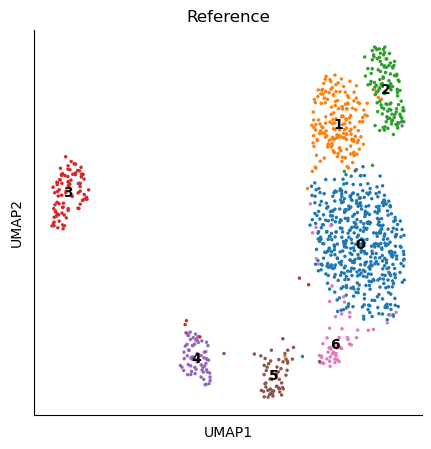

In [25]:
figsize(5,5)
sc.pl.umap(imputeAdata,color=[f'refleiden'],size=25,title='Reference',legend_loc='on data',save='concat')

### max embedding

In [26]:
maxembAdata = sc.AnnData(pd.DataFrame(imputeemb[:,2*768:3*768],index=refdf.index))
sc.pp.scale(maxembAdata)
sc.tl.pca(maxembAdata)
sc.pp.neighbors(maxembAdata)
sc.tl.umap(maxembAdata)
cluster_k_leiden(maxembAdata,numcls)
maxembAdata.obs['refleiden']=refAdata.obs['leiden']

/opt/conda/envs/scvi/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


reference cluster number 7
use resolution 0.5


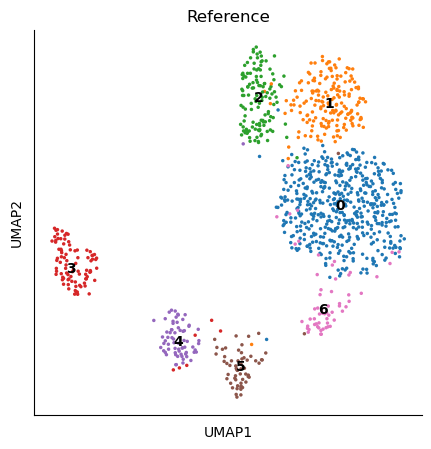

In [27]:
sc.pl.umap(maxembAdata,color=[f'refleiden'],size=25,title='Reference',legend_loc='on data',save='max')

### mean embedding

In [28]:
meanembAdata = sc.AnnData(pd.DataFrame(imputeemb[:,3*768:4*768],index=refdf.index))
sc.pp.scale(meanembAdata)
sc.tl.pca(meanembAdata)
sc.pp.neighbors(meanembAdata)
sc.tl.umap(meanembAdata)
cluster_k_leiden(meanembAdata,numcls)
meanembAdata.obs['refleiden']=refAdata.obs['leiden']

/opt/conda/envs/scvi/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


reference cluster number 7
use resolution 0.5


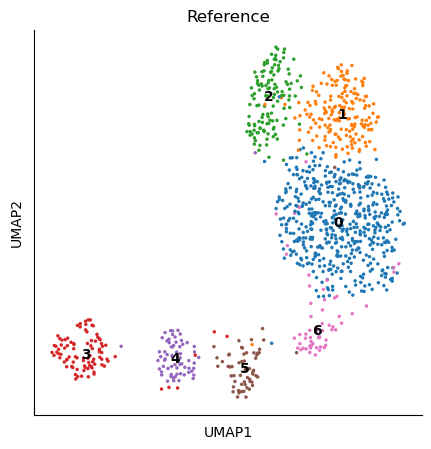

In [29]:
sc.pl.umap(meanembAdata,color=[f'refleiden'],size=25,title='Reference',legend_loc='on data',save='mean')

### S embedding

In [30]:
sembAdata = sc.AnnData(pd.DataFrame(imputeemb[:,0*768:1*768],index=refdf.index))
sc.pp.scale(sembAdata)
sc.tl.pca(sembAdata)
sc.pp.neighbors(sembAdata)
sc.tl.umap(sembAdata)
cluster_k_leiden(sembAdata,numcls)
sembAdata.obs['refleiden']=refAdata.obs['leiden']

/opt/conda/envs/scvi/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


reference cluster number 7
use resolution 0.5


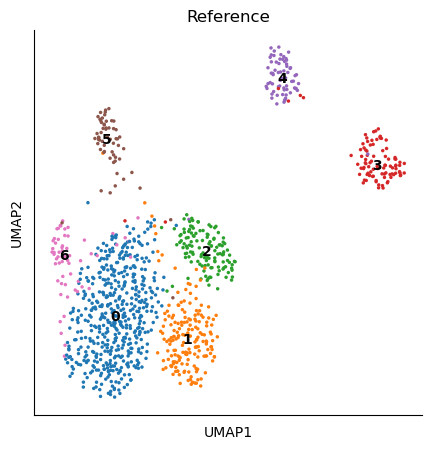

In [31]:
sc.pl.umap(sembAdata,color=[f'refleiden'],size=25,title='Reference',legend_loc='on data',save='token_S')

In [32]:
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score,davies_bouldin_score,calinski_harabasz_score,silhouette_score

alladata = [imputeAdata,maxembAdata,meanembAdata,sembAdata]
name = ['concat','max','mean','token_S']
allscore=[]
for testadata in alladata:
    imputenmi = normalized_mutual_info_score(refAdata.obs[f'leiden'], testadata.obs[f'cluster_7']) 
    imputeari = adjusted_rand_score(refAdata.obs[f'leiden'], testadata.obs[f'cluster_7']) 
    imputesil = silhouette_score(refAdata.obsm['X_pca'],testadata.obs[f'cluster_7'])
    allscore.append([imputenmi,imputeari,imputesil])

In [71]:
results = pd.DataFrame(allscore,index=name,columns=['nmi','ari','sil'])
np.round(results,3)

,nmi,ari,sil
concat,0.911,0.934,0.169
max,0.909,0.937,0.170
mean,0.903,0.932,0.168
token_S,0.877,0.906,0.159


In [34]:
for i in range(4):
    alladata[i].write_h5ad(f'baron/{name[i]}.h5ad')

In [37]:
refAdata.write_h5ad('baron/reference.h5ad')

In [36]:
results.to_csv('baron_results.csv')

## Zheng68K

In [5]:
label = np.load('./data/zheng68kall_label.npy',allow_pickle=True)

In [6]:
refAdata = sc.read_h5ad('./data/zheng68k_reference.h5ad')

### concat embedding

In [8]:
numcls=10
imputeemb = np.load(f'./data/pbmc68ksorted_count_50M-0.1B-res_tgthighres1.0_embedding.npy')
imputeAdata = sc.AnnData(imputeemb)
sc.pp.scale(imputeAdata)
sc.tl.pca(imputeAdata)
sc.pp.neighbors(imputeAdata)
cluster_k_leiden(imputeAdata,numcls)
imputeAdata.obs['refleiden']=label

reference cluster number 10
use resolution 0.171875


In [ ]:
numcls=10
imputeemb = np.load(f'./data/pbmc68ksorted_count_50M-0.1B-res_tgthighres1.0_embedding.npy')
imputeAdata = sc.AnnData(imputeemb)
sc.pp.scale(imputeAdata)
sc.tl.pca(imputeAdata)
sc.pp.neighbors(imputeAdata)
cluster_k_leiden(imputeAdata,numcls)
imputeAdata.obs['refleiden']=label

reference cluster number 10
use resolution 0.171875


### max embedding

In [46]:
maxembAdata = sc.AnnData(imputeemb[:,2*768:3*768])
sc.pp.scale(maxembAdata)
sc.tl.pca(maxembAdata)
sc.pp.neighbors(maxembAdata)
cluster_k_leiden(maxembAdata,numcls)
maxembAdata.obs['refleiden']=label

reference cluster number 10
use resolution 0.171875


### mean embedding

In [47]:
meanembAdata = sc.AnnData(imputeemb[:,3*768:4*768])
sc.pp.scale(meanembAdata)
sc.tl.pca(meanembAdata)
sc.pp.neighbors(meanembAdata)
cluster_k_leiden(meanembAdata,numcls)
meanembAdata.obs['refleiden']=label

reference cluster number 10
use resolution 0.1875


### S embedding

In [49]:
sembAdata = sc.AnnData(imputeemb[:,0*768:1*768])
sc.pp.scale(sembAdata)
sc.tl.pca(sembAdata)
sc.pp.neighbors(sembAdata)
cluster_k_leiden(sembAdata,numcls)
sembAdata.obs['refleiden']=label

reference cluster number 10
use resolution 0.171875


In [58]:
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score,davies_bouldin_score,calinski_harabasz_score,silhouette_score

alladata = [imputeAdata,maxembAdata,meanembAdata,sembAdata]
name = ['concat','max','mean','token_S']
allscore=[]
for testadata in alladata:
    imputenmi = normalized_mutual_info_score(label, testadata.obs[f'cluster_10']) 
    imputeari = adjusted_rand_score(label, testadata.obs[f'cluster_10']) 
    imputesil = silhouette_score(refAdata.obsm['X_pca'],testadata.obs[f'cluster_10'])
    allscore.append([imputenmi,imputeari,imputesil])

In [64]:
results = pd.DataFrame(allscore,index=name,columns=['nmi','ari','sil'])
np.round(results,3)

,nmi,ari,sil
concat,0.785,0.574,0.097
max,0.758,0.563,0.104
mean,0.787,0.576,0.095
token_S,0.770,0.604,0.096


In [65]:
for i in range(4):
    alladata[i].write_h5ad(f'zheng68k/{name[i]}.h5ad')

In [67]:
refAdata.write_h5ad('zheng68k/reference.h5ad')

In [68]:
results.to_csv('zheng_results.csv')